Import Statment

In [ ]:
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.initializers import Constant
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Embedding, Dropout, Flatten, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Embedding
from sklearn.metrics import confusion_matrix
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from matplotlib.pyplot import figure
import seaborn as sn
import pandas as pd
import numpy as np
import string


Loading Data

In [ ]:
samples = open("emotion.txt","r", encoding="utf8")
lyrics = []
Y = []

# I have pre-process the data will web scraping in order to avoid overflowing url request
for a_sample in samples:
  if a_sample[0] == " ":
    continue
  lyrics.append(a_sample[2:-2])
  Y.append(int(a_sample[0]))

**Pie** Chart Dataset

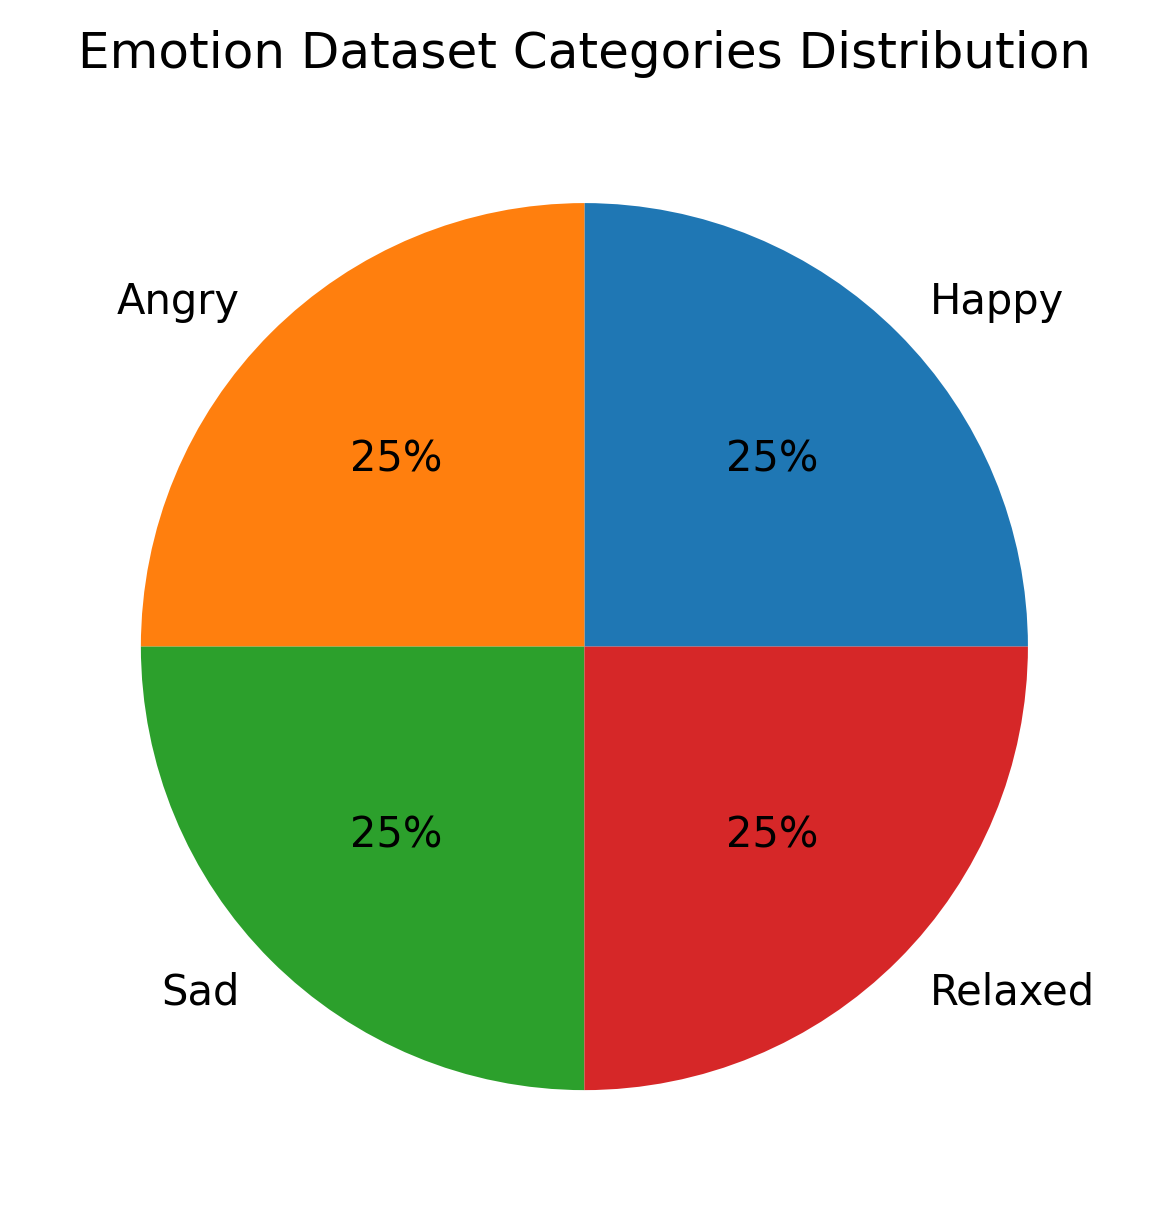

In [ ]:
categories = {"Happy":0, "Angry": 0, "Sad": 0, "Relaxed":0}
for cat in Y:
  if cat == 1:
    categories["Happy"] = categories["Happy"] + 1
  elif cat == 2:
    categories["Angry"] = categories["Angry"] + 1
  elif cat == 3:
    categories["Sad"] = categories["Sad"] + 1
  elif cat == 4:
    categories["Relaxed"] = categories["Relaxed"] + 1

cat = categories.keys()
val = []
for keys in cat:
  val.append(categories[keys])

plt.figure(dpi=300)
plt.pie(val, labels = cat, autopct='%1.0f%%')
plt.title('Emotion Dataset Categories Distribution')
plt.savefig("./image/Emopie")
plt.show()

**Tokenization**

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Tokenizing lyrics
X = []
for lyric in lyrics:
    tokens = word_tokenize(lyric)
    X.append(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Embedding

In [ ]:
filename = './glove.6B.100d.txt'

# Collection Word relationship
file = open(filename, encoding = "utf-8")
embed_DB = {}
for a_line in file:
    embedding = a_line.split()
    the_word = embedding[0]
    context_array = embedding[1:]
    embed_DB[the_word] = np.asarray(context_array)
file.close()

# Tokenizing lyrics words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
x_sequence = tokenizer.texts_to_sequences(X)

highest_tokens = max([len(tokenized_lyric) for tokenized_lyric in X])
x_sequence_zero = pad_sequences(x_sequence, maxlen=highest_tokens)

word_index = tokenizer.word_index
total_words = len(word_index) + 1

embed_mat = np.zeros((total_words, 100))

# Making embedding matrix
for word, index in word_index.items():
    if index > total_words:
        continue

    embed_vec = embed_DB.get(word)
    # edge cases
    if embed_vec is None:
      continue

    embed_mat[index] = embed_vec

embedding_layer = Embedding(total_words, 100, embeddings_initializer=Constant(embed_mat), input_length=highest_tokens,trainable=False)

Sperating Training and Test Dataset

In [ ]:
Y = np.array(Y)
encoder = LabelBinarizer()
Y = encoder.fit_transform(Y.tolist())
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)

Functions to calculate recall, precision and F1 score

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Model and Training

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(128, 16, activation='relu'))
model.add(Conv1D(64, 8, activation='relu'))
model.add(Conv1D(32, 8, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
history_model = model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_data=(X_test, Y_train), verbose=2)

Epoch 1/10
94/94 - 3s - loss: 0.6098 - accuracy: 0.3153 - f1_m: 0.2571 - precision_m: 0.4079 - recall_m: 0.1981 - val_loss: 0.5342 - val_accuracy: 0.5260 - val_f1_m: 0.4000 - val_precision_m: 0.7292 - val_recall_m: 0.2832 - 3s/epoch - 31ms/step
Epoch 2/10
94/94 - 1s - loss: 0.4702 - accuracy: 0.5907 - f1_m: 0.5552 - precision_m: 0.7342 - recall_m: 0.4610 - val_loss: 0.3976 - val_accuracy: 0.6880 - val_f1_m: 0.6811 - val_precision_m: 0.7928 - val_recall_m: 0.6035 - 508ms/epoch - 5ms/step
Epoch 3/10
94/94 - 0s - loss: 0.3522 - accuracy: 0.6753 - f1_m: 0.6807 - precision_m: 0.7780 - recall_m: 0.6099 - val_loss: 0.3389 - val_accuracy: 0.7300 - val_f1_m: 0.6752 - val_precision_m: 0.8259 - val_recall_m: 0.5762 - 500ms/epoch - 5ms/step
Epoch 4/10
94/94 - 0s - loss: 0.2840 - accuracy: 0.7387 - f1_m: 0.7358 - precision_m: 0.8023 - recall_m: 0.6848 - val_loss: 0.2808 - val_accuracy: 0.7600 - val_f1_m: 0.7533 - val_precision_m: 0.8244 - val_recall_m: 0.6953 - 499ms/epoch - 5ms/step
Epoch 5/10
94/

Confusion Matrix

16/16 [==============================] - 0s 2ms/step


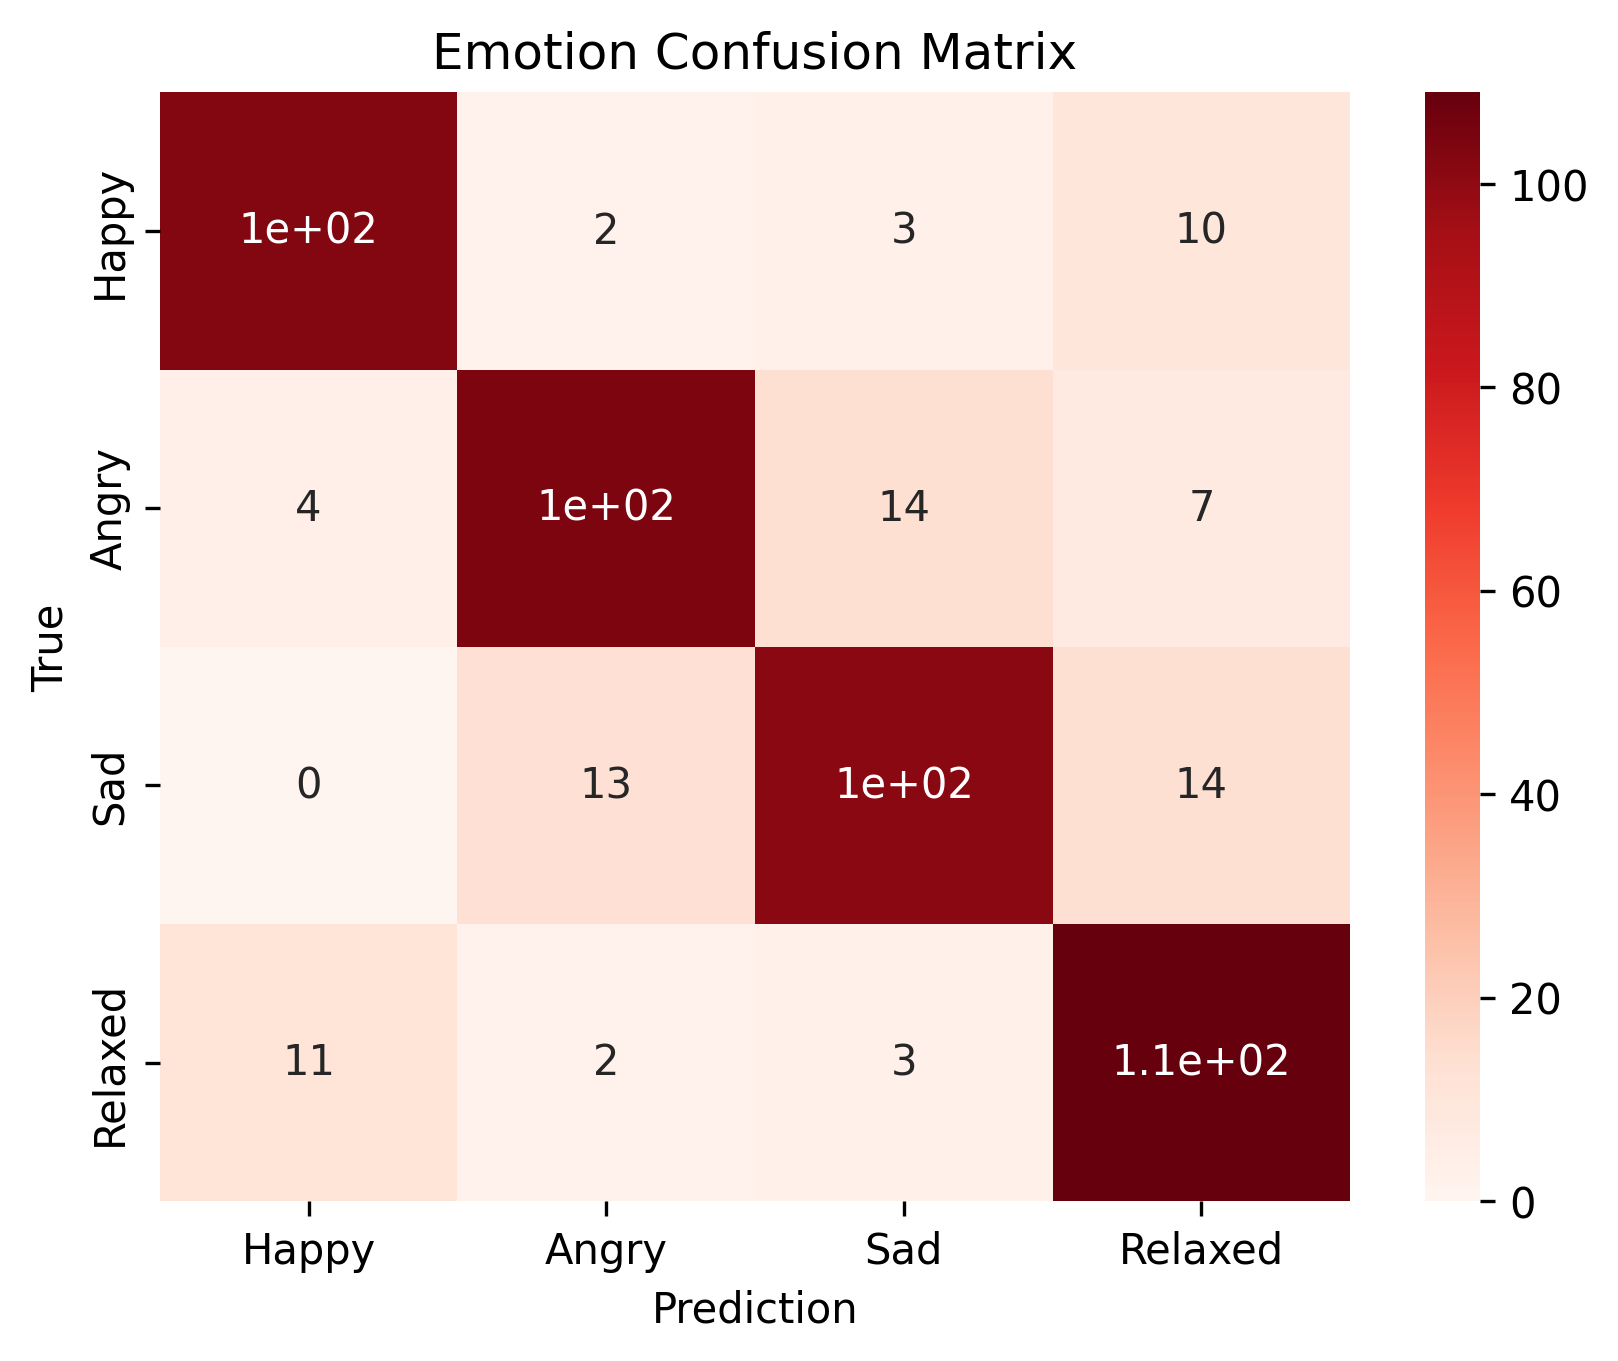

In [ ]:
Y_pred = model.predict(X_test)

y_pred_cat = np.zeros(len(Y_pred), dtype=int)
y_test_cat = np.zeros(len(Y_pred), dtype=int)

for index, label in enumerate(Y_pred):
    y_pred_cat[index] = np.argmax(Y_pred[index])

for index, label in enumerate(Y_pred):
    y_test_cat[index] = np.argmax(Y_pred[index])

confusion_mat = confusion_matrix(y_test_cat, y_pred_cat)
confusion_df = pd.DataFrame(confusion_mat, index = ['Happy', 'Angry', 'Sad', 'Relaxed',], columns = ['Happy', 'Angry', 'Sad', 'Relaxed',])


figure(dpi=300)
sn.heatmap(confusion_df, annot=True, cmap=plt.cm.Reds, cbar=True)
plt.title('Emotion Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("True")
plt.savefig("./image/Emo confusion mat")
plt.show()

Accuracy

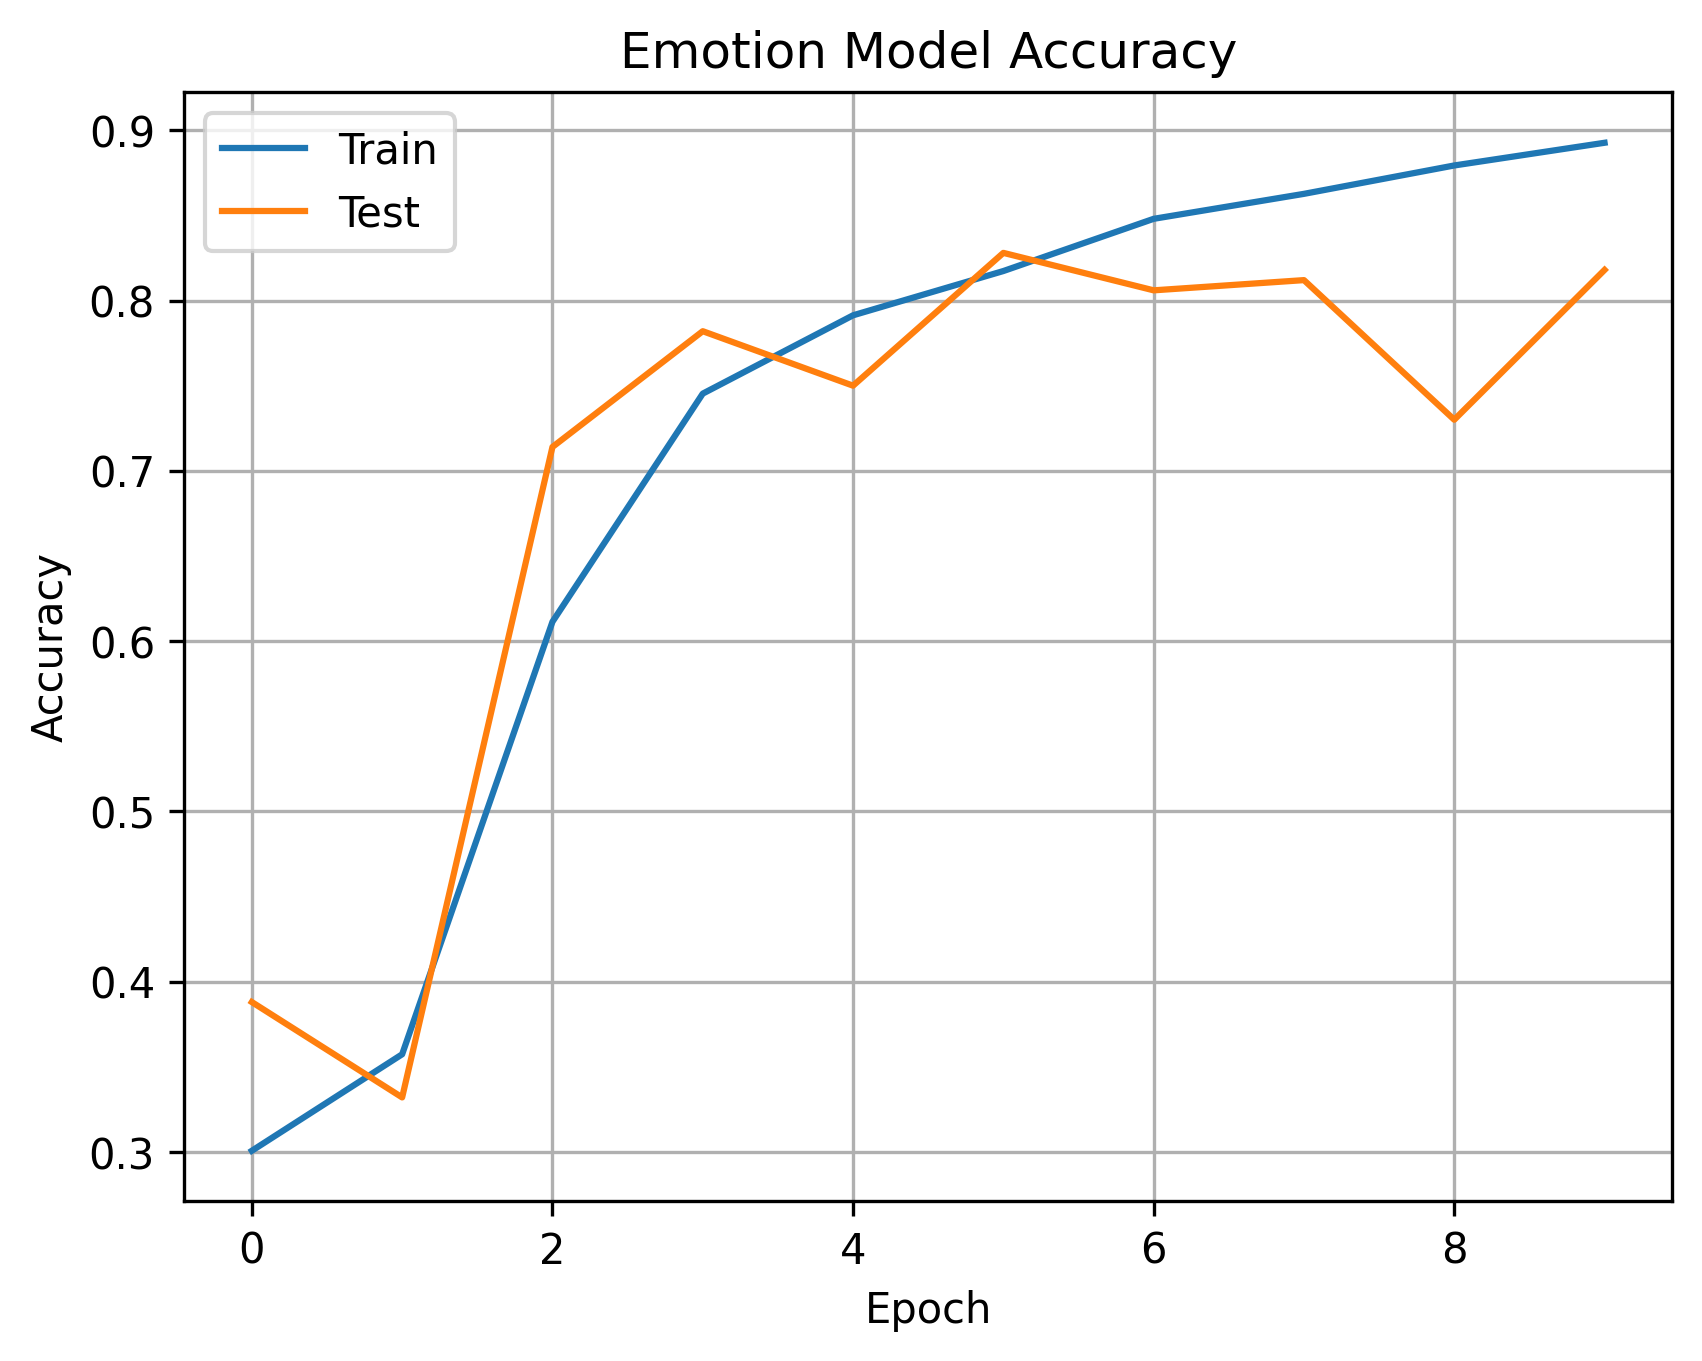

In [ ]:
figure(dpi=300)
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.legend(['Train', 'Test'])
plt.title('Emotion Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.savefig("./image/Emo accuracy mat")
plt.show()

Loss

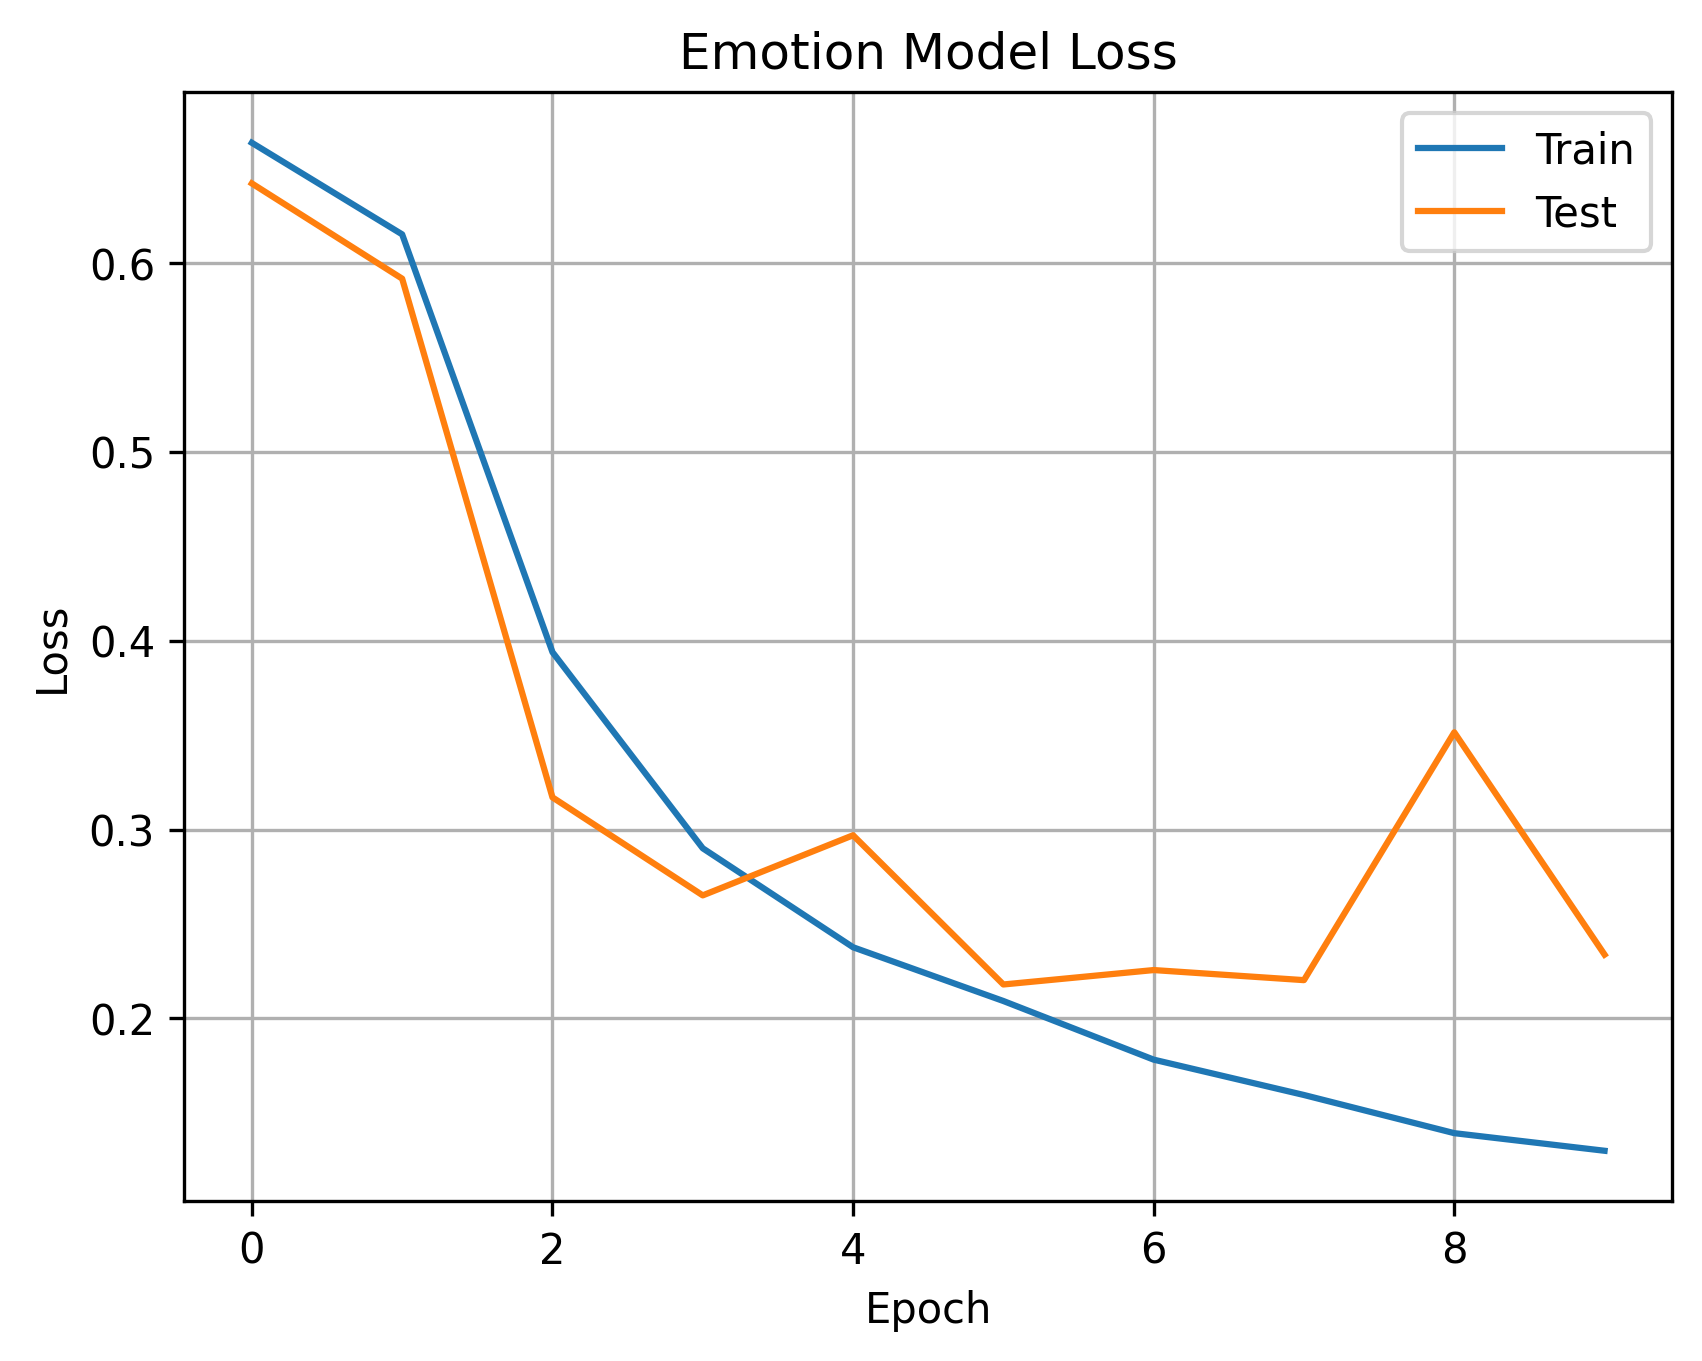

In [ ]:
figure(dpi=300)
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.title('Emotion Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.savefig("./image/Emo loss mat")
plt.show()

In [ ]:
print(plt.legend(['Train', 'Test']).history.keys())

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


Recall

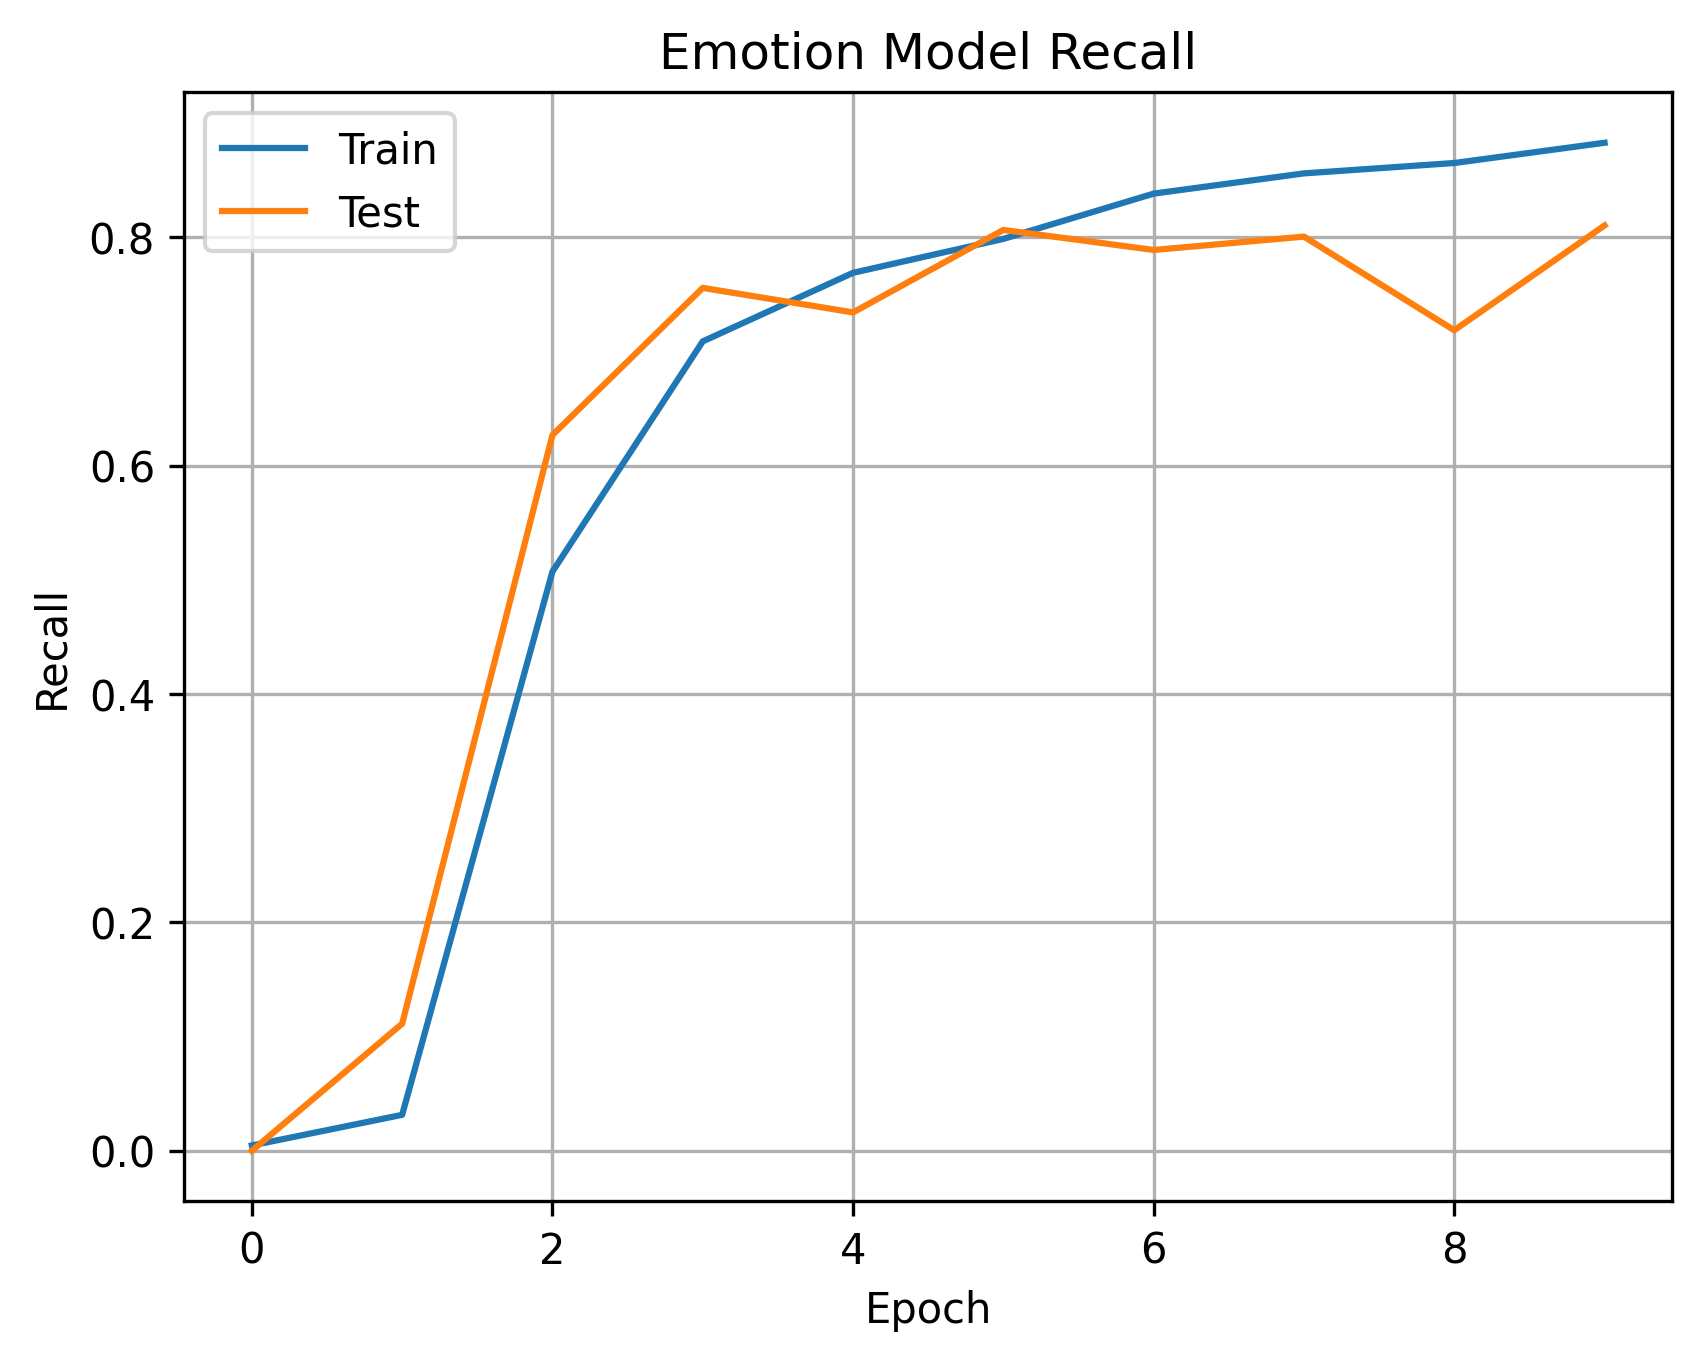

In [ ]:
figure(dpi=300)
plt.plot(history_model.history['recall_m'])
plt.plot(history_model.history['val_recall_m'])
plt.legend(['Train', 'Test'])
plt.title('Emotion Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.savefig("./image/Emo recall mat")
plt.show()

Precsion

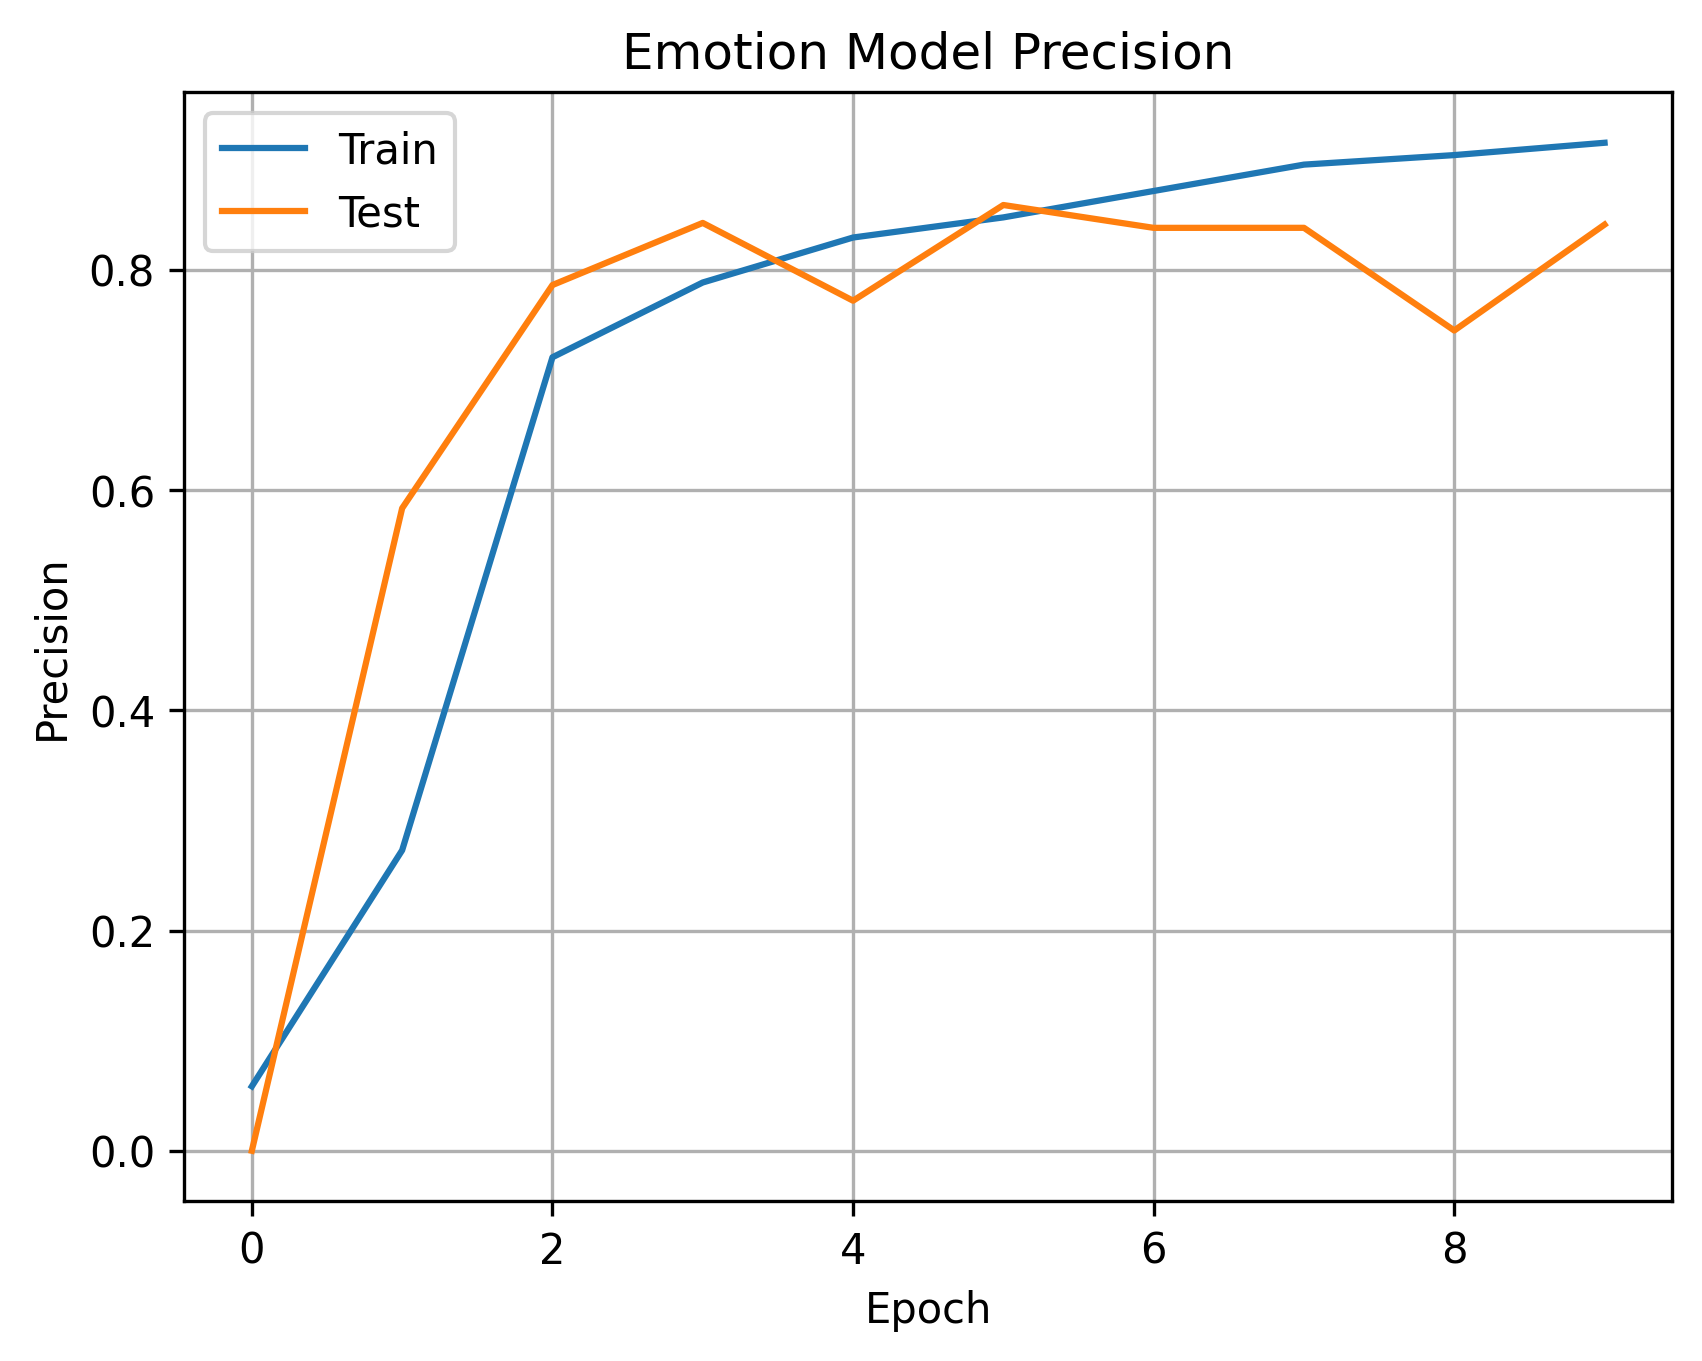

In [ ]:
figure(dpi=300)
plt.plot(history_model.history['precision_m'])
plt.plot(history_model.history['val_precision_m'])
plt.legend(['Train', 'Test'])
plt.title('Emotion Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.grid(True)
plt.savefig("./image/Emo precision mat")
plt.show()

F1 score

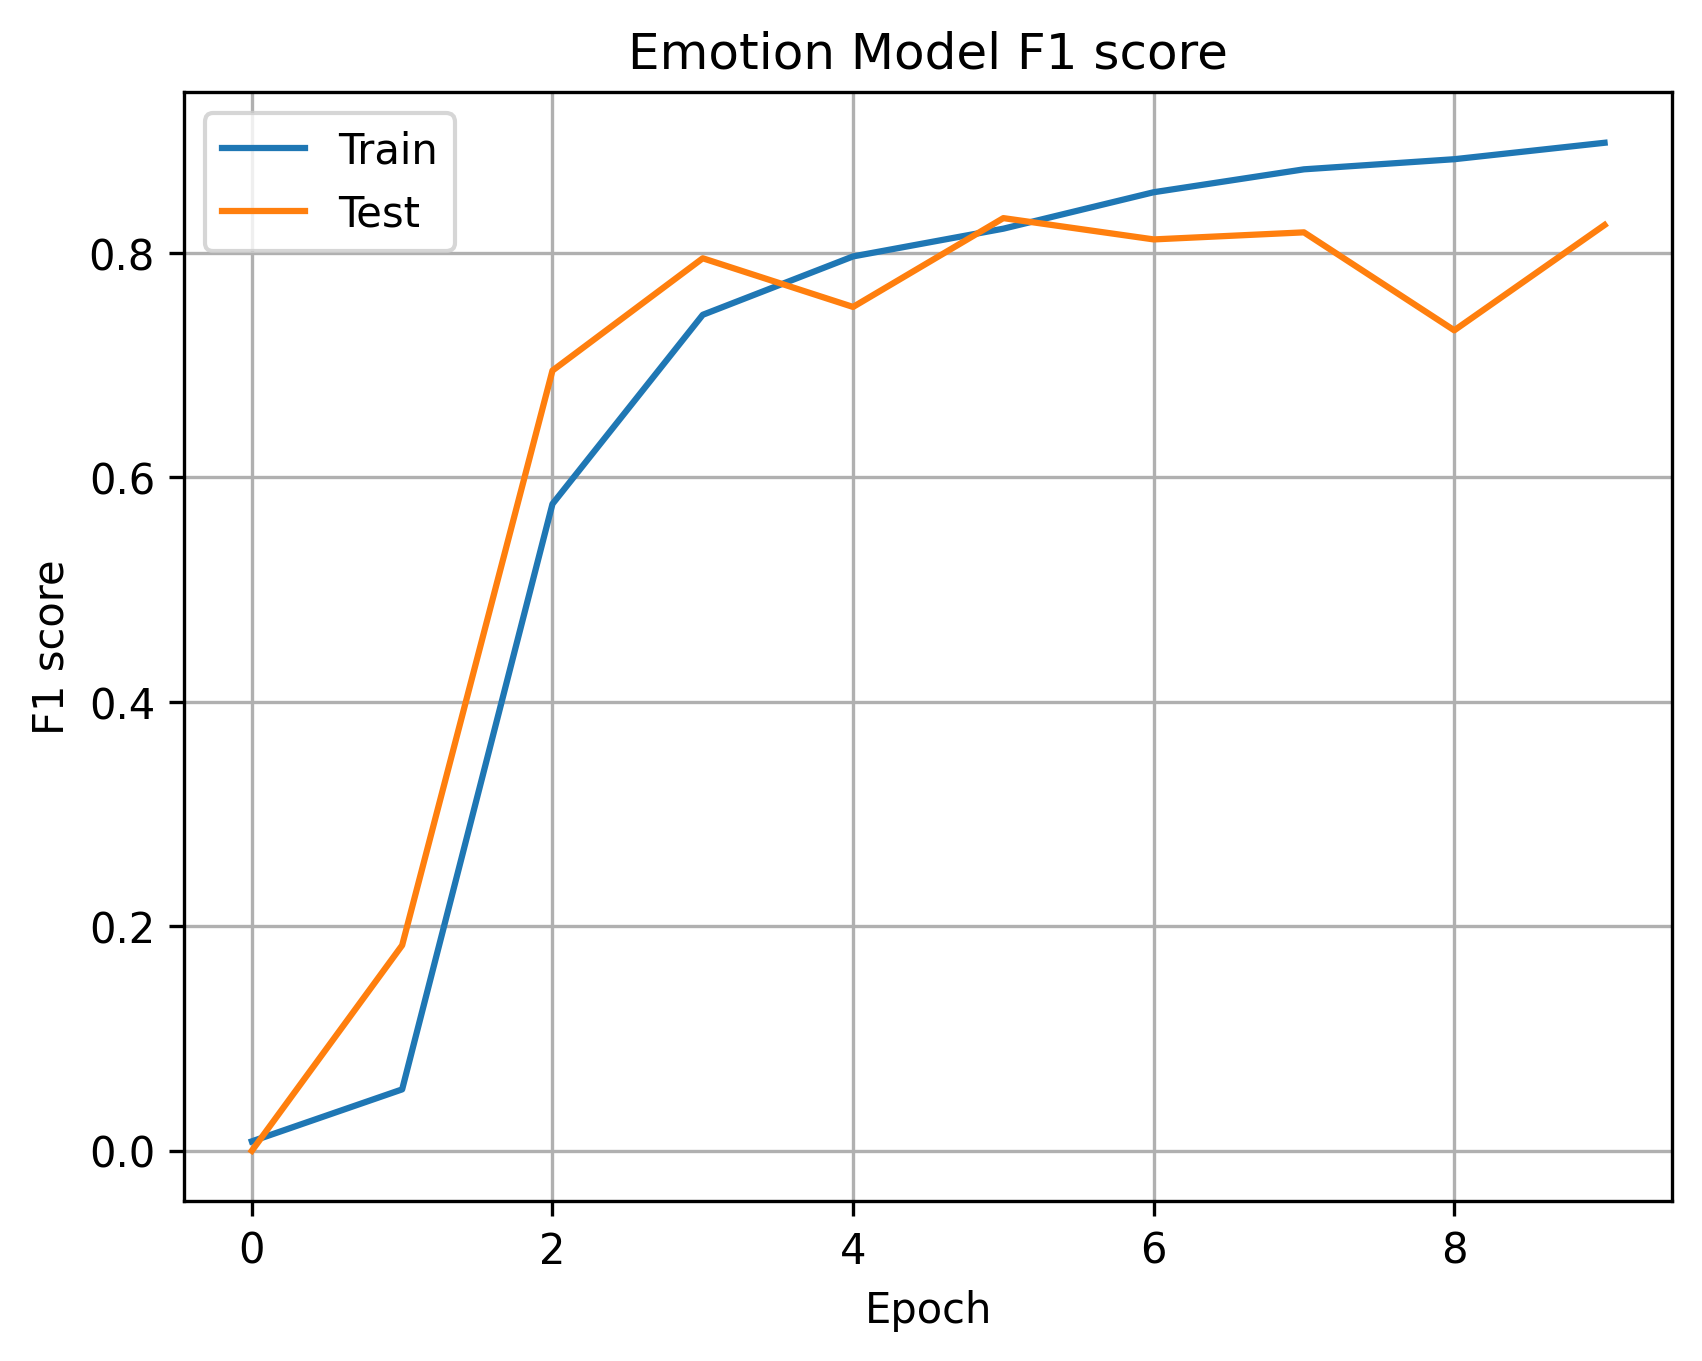

In [ ]:
figure(dpi=300)
plt.plot(history_model.history['f1_m'])
plt.plot(history_model.history['val_f1_m'])
plt.legend(['Train', 'Test'])
plt.title('Emotion Model F1 score')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.grid(True)
plt.savefig("./image/Emo f1 mat")
plt.show()

Model Summary

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 584, 100)          1389800   
                                                                 
 dropout_1 (Dropout)         (None, 584, 100)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 569, 128)          204928    
                                                                 
 conv1d_4 (Conv1D)           (None, 562, 64)           65600     
                                                                 
 conv1d_5 (Conv1D)           (None, 555, 32)           16416     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                      

Model Diagram

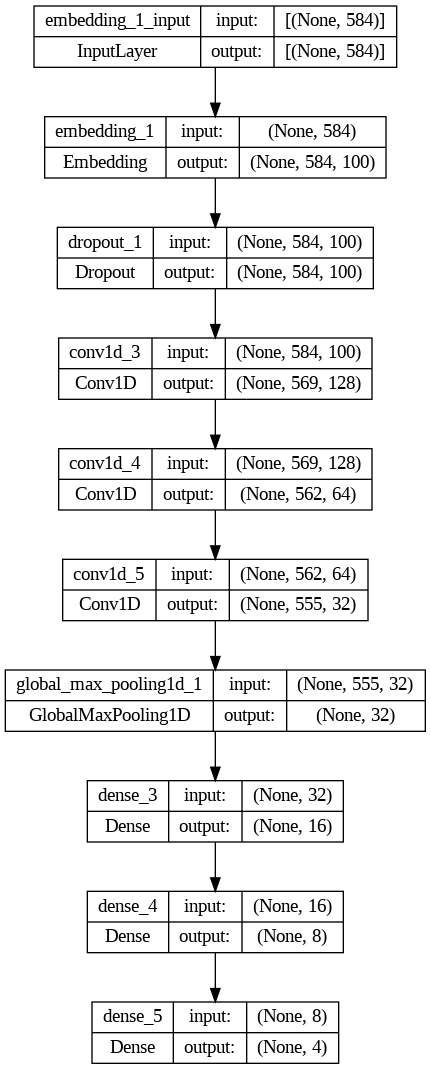

In [ ]:
plot_model(model, to_file='./image/emodiagram.png', show_shapes=True, show_layer_names=True)